In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/IDS")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import sklearn.utils
from keras import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
#%matplotlib notebook
#%matplotlib inline #this was active
import scipy, pylab

In [3]:
file_name = 'andmed.csv'
df = pd.read_csv(file_name, delimiter=",", decimal=',')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12388 entries, 0 to 12387
Data columns (total 22 columns):
 #   Column                                                                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                                                                          --------------  -----  
 0   Time                                                                                                                                                            12361 non-null  float64
 1   Time Code                                                                                                                                                       12361 non-null  object 
 2   Country Name                                                                                                                      

We have 12388 rows and 20 columns in our raw dataframe.

In [5]:
cols = list(df.columns)
for c in cols:
  print(c)
  print(df[c].isnull().sum())
  print()

total = df.size - df.count().sum()
print('Total sum of NaNs in the dataframe:', total)

Time
27

Time Code
27

Country Name
27

Percentage of graduates from tertiary education graduating from Agriculture, Forestry, Fisheries and Veterinary programmes, both sexes (%) [SE.TER.GRAD.AG.ZS]
11327

Government expenditure on education as % of GDP (%) [SE.XPD.TOTL.GD.ZS]
8237

Enrolment in tertiary education, all programmes, both sexes (number) [SE.TER.ENRL]
4677

Percentage of graduates from tertiary education graduating from Natural Sciences, Mathematics and Statistics programmes, both sexes (%) [SE.TER.GRAD.SC.ZS]
11330

Enrolment in primary education, both sexes (number) [SE.PRM.ENRL]
2711

Energy use (kg of oil equivalent per capita)
4816

GDP per capita growth (annual %)
2391

CO2 emissions (metric tons per capita)
1488

Industry (including construction), value added (annual % growth)
4732

Manufacturing, value added (annual % growth)
5834

Urban population (% of total population)
166

Merchandise imports (current US$)
1873

Merchandise exports (current US$)
1869

Populatio

We have many missing values in our dataframe. Total sum of NaN's is 78125.

In [6]:
#Drop dublicated columns, columns with large amount of Nan's and columns that has no mean to find features that impact CO2 emissions
df = df.drop(columns=['Merchandise exports (current US$)','Merchandise imports (current US$)','Industry (including construction), value added (annual % growth)','Time', 'Country Name', 'Time Code', 'Country Code_y', 'CO2 emissions (metric tons per capita) [EN.ATM.CO2E.PC]', 'Percentage of graduates from tertiary education graduating from Agriculture, Forestry, Fisheries and Veterinary programmes, both sexes (%) [SE.TER.GRAD.AG.ZS]', 'Percentage of graduates from tertiary education graduating from Natural Sciences, Mathematics and Statistics programmes, both sexes (%) [SE.TER.GRAD.SC.ZS]', 'Government expenditure on education as % of GDP (%) [SE.XPD.TOTL.GD.ZS]'])

In [7]:
#In the columns with little NaN's we replace missing values with the mean of the column
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df[['Urban population (% of total population)','Population growth (annual %)']] = imp.fit_transform(df[['Urban population (% of total population)','Population growth (annual %)']])

In [8]:
#Drop rows that include NaN's.
data = df.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3259 entries, 274 to 12090
Data columns (total 11 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   Enrolment in tertiary education, all programmes, both sexes (number) [SE.TER.ENRL]  3259 non-null   object 
 1   Enrolment in primary education, both sexes (number) [SE.PRM.ENRL]                   3259 non-null   object 
 2   Energy use (kg of oil equivalent per capita)                                        3259 non-null   float64
 3   GDP per capita growth (annual %)                                                    3259 non-null   float64
 4   CO2 emissions (metric tons per capita)                                              3259 non-null   float64
 5   Manufacturing, value added (annual % growth)                                        3259 non-n

As we see our preprocessed dataframe has 3259 rows and 10 columns (9 features and 1 label). We think that the size of the dataset is large enough to achieve the goal of our project.

In [9]:
#Create list of columns and transform all object type data to float64.
cols = list(data.columns)
data[cols] = data[cols].apply(pd.to_numeric)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3259 entries, 274 to 12090
Data columns (total 11 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   Enrolment in tertiary education, all programmes, both sexes (number) [SE.TER.ENRL]  3259 non-null   float64
 1   Enrolment in primary education, both sexes (number) [SE.PRM.ENRL]                   3259 non-null   float64
 2   Energy use (kg of oil equivalent per capita)                                        3259 non-null   float64
 3   GDP per capita growth (annual %)                                                    3259 non-null   float64
 4   CO2 emissions (metric tons per capita)                                              3259 non-null   float64
 5   Manufacturing, value added (annual % growth)                                        3259 non-n

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [10]:
#Recursive method to find combinations in list
def combinations(L):
  if len(L) == 0:
    return [[]]
  result = []
  for c in combinations(L[1:]):
    result += [c, c+[L[0]]]
  return result

c = combinations(['x','y','z'])[1:]
print(c)

[['x'], ['y'], ['y', 'x'], ['z'], ['z', 'x'], ['z', 'y'], ['z', 'y', 'x']]


In [11]:
#Find the best model (with default settings) and the best combination of features 
#that gives the smallest mean absolute error and mean square error. 

#Dictionary to keep the best combinations.
best_combinations = {}

data_copy = data.copy()
features = list(data_copy.columns)
features.remove('CO2 emissions (metric tons per capita)')

X = data_copy[features]
y = data_copy[['CO2 emissions (metric tons per capita)']]

models = [LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor(criterion='mae'), 
          MultiOutputRegressor(RandomForestRegressor(max_depth=5, random_state=0))]

features = combinations(features)[1:]


for model in models:
  best = 100
  combi = ""

  for f in features:
    X_train, X_test, y_train, y_test = train_test_split(X[f].values, y.values, test_size=0.3, random_state=12)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    result = np.mean(np.abs(y_test - y_pred))
    if result < best:
      best = result
      combi = f

  #Add best combinations to the dictionary
  #best_combinations[model] = [best, combi]
  model_name = type(model).__name__
  best_combinations[model_name] = [best, combi]

  print("Results for model:", model_name)
  print("Combination:", combi)
  print("Mean absolute error", best)
  print()

Results for model: LinearRegression
Combination: ['Fossil fuel energy consumption (% of total)', 'Alternative and nuclear energy (% of total energy use)', 'Manufacturing, value added (annual % growth)', 'GDP per capita growth (annual %)', 'Energy use (kg of oil equivalent per capita)', 'Enrolment in primary education, both sexes (number) [SE.PRM.ENRL]']
Mean absolute error 1.051874781530802

Results for model: KNeighborsRegressor
Combination: ['Fossil fuel energy consumption (% of total)', 'Alternative and nuclear energy (% of total energy use)', 'Urban population (% of total population)']
Mean absolute error 0.787743698906135

Results for model: DecisionTreeRegressor
Combination: ['Urban population (% of total population)', 'Manufacturing, value added (annual % growth)', 'GDP per capita growth (annual %)']
Mean absolute error 4.6948517038375845

Results for model: MultiOutputRegressor
Combination: ['Fossil fuel energy consumption (% of total)', 'Alternative and nuclear energy (% of to

In [12]:
for k, v in best_combinations.items():
  print(k, v)

LinearRegression [1.051874781530802, ['Fossil fuel energy consumption (% of total)', 'Alternative and nuclear energy (% of total energy use)', 'Manufacturing, value added (annual % growth)', 'GDP per capita growth (annual %)', 'Energy use (kg of oil equivalent per capita)', 'Enrolment in primary education, both sexes (number) [SE.PRM.ENRL]']]
KNeighborsRegressor [0.787743698906135, ['Fossil fuel energy consumption (% of total)', 'Alternative and nuclear energy (% of total energy use)', 'Urban population (% of total population)']]
DecisionTreeRegressor [4.6948517038375845, ['Urban population (% of total population)', 'Manufacturing, value added (annual % growth)', 'GDP per capita growth (annual %)']]
MultiOutputRegressor [0.5225720801355809, ['Fossil fuel energy consumption (% of total)', 'Alternative and nuclear energy (% of total energy use)', 'Urban population (% of total population)', 'Energy use (kg of oil equivalent per capita)', 'Enrolment in primary education, both sexes (number

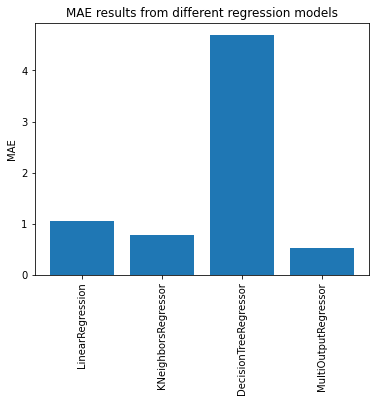

In [13]:
#Graph from the regression models results
y_pos = np.arange(len(best_combinations))
names = ()
height = []
for k, v in best_combinations.items():
  height.append(v[0])
  #names = names + (type(k).__name__,)
  names = names + (k, )

plt.bar(y_pos, height)

plt.xticks(y_pos, names, rotation=90)

plt.ylabel("MAE")
plt.title("MAE results from different regression models")
plt.subplots_adjust(top=1)
plt.savefig("MAE results.png")


In [14]:
#Function to find difference between two lists
def diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))

In [15]:
#PREPROCESSING DATA FOR NEURAL NETWORK.

data_copy = data.copy()
cols = list(data_copy.columns)

#For neural network it's better to have values between 0 and 1 or -1 to 1 in case of negative values in the column.

#Find features with negative values.
features_neg = data_copy.columns[(data_copy < 0).any()].tolist()

#Columns containing negative values normalize to values between -1 and 1
scaler_neg = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
data_copy[features_neg] = scaler_neg.fit_transform(data_copy[features_neg])

features = diff(cols, features_neg)

#Normalize other features values between 0 and 1. 
scaler = sklearn.preprocessing.MinMaxScaler()
data_copy[features] = scaler.fit_transform(data_copy[features])

#Normalize label.
scalar = sklearn.preprocessing.MinMaxScaler()
data_copy[['CO2 emissions (metric tons per capita)']] = scalar.fit_transform(data_copy[['CO2 emissions (metric tons per capita)']])

Epoch 1/20
286/286 [==============================] - 0s 1ms/step - loss: 0.3195 - val_loss: 0.1975
Epoch 2/20
286/286 [==============================] - 0s 1ms/step - loss: 0.1305 - val_loss: 0.0911
Epoch 3/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0741 - val_loss: 0.0684
Epoch 4/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0613
Epoch 5/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0561 - val_loss: 0.0582
Epoch 6/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0540 - val_loss: 0.0567
Epoch 7/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0529 - val_loss: 0.0557
Epoch 8/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0521 - val_loss: 0.0549
Epoch 9/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0515 - val_loss: 0.0543
Epoch 10/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0510 - val_loss: 0.0537

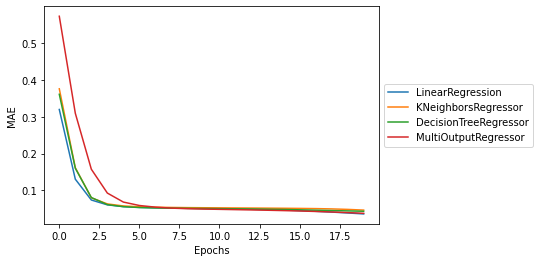

In [16]:
#Test the best combinations of features from regression models with neural network and find MAE.

best_features = []
for k, v in best_combinations.items():
  best_features.append(v[1])

features = list(data_copy.columns)
features.remove('CO2 emissions (metric tons per capita)')

X = data_copy[features]
y = data_copy[['CO2 emissions (metric tons per capita)']]

best = ""
mae = 100
losses = []

#for f in best_features:
for k, v in best_combinations.items():

  X_train, X_test, y_train, y_test = train_test_split(X[v[1]].values, y.values, test_size=0.3, random_state=12)

  #Create simple neural network model
  model = Sequential() 

  model.add(Dense(4, activation="sigmoid", input_shape=(X_train.shape[1],)))
  model.add(Dense(1, activation="sigmoid"))

  #model.summary()

  model.compile(loss="mean_absolute_error", optimizer="adam")

  hist = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=20, batch_size = 8, verbose=True)
  plt.plot(hist.history["loss"], label=k)

  y_pred = model.predict(X_test)

  #Convert feature values back to it's original values
  y_pred = scalar.inverse_transform(y_pred)
  y_test = scalar.inverse_transform(y_test)

  result = np.mean(np.abs(y_test - y_pred))
  print(v[1])
  print(result)

  if result < mae:
    best = v[1]
    mae = result

print("The best combination from regression models is", '\n', best, '\n', "with MAE", mae)

plt.ylabel("MAE")
plt.xlabel("Epochs")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig("Neural network MAE.png")


In [17]:
#Test the best combinations of features with neural network and find MAE.

features = list(data_copy.columns)
features.remove('CO2 emissions (metric tons per capita)')
X = data_copy[features]
y = data_copy[['CO2 emissions (metric tons per capita)']]

features = combinations(features)[1:]

best = 100
best_mse = 100
f_mae = ""
count = len(features)

for f in features:
  count -= 1
  print(count)
  X_train, X_test, y_train, y_test = train_test_split(X[f].values, y.values, test_size=0.3, random_state=12)

  #Create simple neural network model
  model = Sequential() 

  model.add(Dense(4, activation="sigmoid", input_shape=(X_train.shape[1],)))
  model.add(Dense(1, activation="sigmoid"))

  #model.summary()

  model.compile(loss="mean_absolute_error", optimizer="adam")

  #increase batch-size to make model faster
  model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=20, batch_size=256, verbose=True)

  y_pred = model.predict(X_test)

  #Convert feature values back to it's original values
  y_pred = scalar.inverse_transform(y_pred)
  y_test = scalar.inverse_transform(y_test)

  result = np.mean(np.abs(y_test - y_pred))

  if result < best:
    best = result
    f_mae = f

print("The best combination of MAE:", f_mae)
print("MAE:", best)


Voogesituse väljund on kärbitud viimase 5000 reani.
9/9 [==============================] - 0s 4ms/step - loss: 0.6651 - val_loss: 0.6584
Epoch 3/20
9/9 [==============================] - 0s 4ms/step - loss: 0.6577 - val_loss: 0.6510
Epoch 4/20
9/9 [==============================] - 0s 4ms/step - loss: 0.6502 - val_loss: 0.6434
Epoch 5/20
9/9 [==============================] - 0s 4ms/step - loss: 0.6426 - val_loss: 0.6358
Epoch 6/20
9/9 [==============================] - 0s 4ms/step - loss: 0.6349 - val_loss: 0.6279
Epoch 7/20
9/9 [==============================] - 0s 4ms/step - loss: 0.6270 - val_loss: 0.6200
Epoch 8/20
9/9 [==============================] - 0s 4ms/step - loss: 0.6190 - val_loss: 0.6120
Epoch 9/20
9/9 [==============================] - 0s 4ms/step - loss: 0.6109 - val_loss: 0.6038
Epoch 10/20
9/9 [==============================] - 0s 4ms/step - loss: 0.6027 - val_loss: 0.5955
Epoch 11/20
9/9 [==============================] - 0s 4ms/step - loss: 0.5944 - val_loss: 0.58

In [18]:
best_combinations['Neural network'] = [best, f_mae]

In [19]:
for k, v in best_combinations.items():
  print(k,v)

LinearRegression [1.051874781530802, ['Fossil fuel energy consumption (% of total)', 'Alternative and nuclear energy (% of total energy use)', 'Manufacturing, value added (annual % growth)', 'GDP per capita growth (annual %)', 'Energy use (kg of oil equivalent per capita)', 'Enrolment in primary education, both sexes (number) [SE.PRM.ENRL]']]
KNeighborsRegressor [0.787743698906135, ['Fossil fuel energy consumption (% of total)', 'Alternative and nuclear energy (% of total energy use)', 'Urban population (% of total population)']]
DecisionTreeRegressor [4.6948517038375845, ['Urban population (% of total population)', 'Manufacturing, value added (annual % growth)', 'GDP per capita growth (annual %)']]
MultiOutputRegressor [0.5225720801355809, ['Fossil fuel energy consumption (% of total)', 'Alternative and nuclear energy (% of total energy use)', 'Urban population (% of total population)', 'Energy use (kg of oil equivalent per capita)', 'Enrolment in primary education, both sexes (number

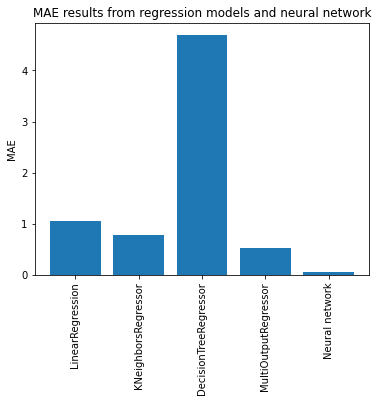

In [20]:
y_pos = np.arange(len(best_combinations))
names = ()
height = []
for k, v in best_combinations.items():
  height.append(v[0])
  names = names + (k, )

plt.bar(y_pos, height)

plt.xticks(y_pos, names, rotation=90)

plt.ylabel("MAE")
plt.title("MAE results from regression models and neural network")
plt.subplots_adjust(top=1)
#plt.savefig("MAE results.png")


Epoch 1/20
286/286 [==============================] - 0s 1ms/step - loss: 0.3878 - val_loss: 0.2593
Epoch 2/20
286/286 [==============================] - 0s 1ms/step - loss: 0.1726 - val_loss: 0.1106
Epoch 3/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0823 - val_loss: 0.0692
Epoch 4/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0599
Epoch 5/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0540 - val_loss: 0.0562
Epoch 6/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0514 - val_loss: 0.0544
Epoch 7/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0502 - val_loss: 0.0536
Epoch 8/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0498 - val_loss: 0.0532
Epoch 9/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0495 - val_loss: 0.0529
Epoch 10/20
286/286 [==============================] - 0s 1ms/step - loss: 0.0493 - val_loss: 0.0528

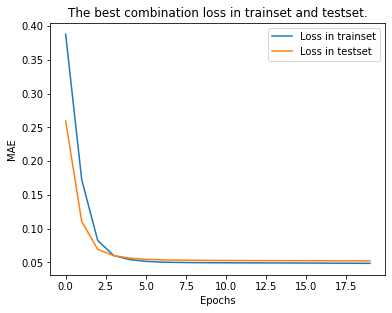

In [21]:
#The best combination of features from neural network.
test_combination = best_combinations['Neural network'][1]

features = list(data_copy.columns)
features.remove('CO2 emissions (metric tons per capita)')

X = data_copy[features]
y = data_copy[['CO2 emissions (metric tons per capita)']]

best = ""
mae = 100

X_train, X_test, y_train, y_test = train_test_split(X[test_combination].values, y.values, test_size=0.3, random_state=12)

#Create simple neural network model
model = Sequential() 
model.add(Dense(4, activation="sigmoid", input_shape=(X_train.shape[1],)))
model.add(Dense(1, activation="sigmoid"))

#model.summary()

model.compile(loss="mean_absolute_error", optimizer="adam")

hist = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=20, batch_size = 8, verbose=True)
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.legend(['Loss in trainset', 'Loss in testset'], loc='upper right')

y_pred = model.predict(X_test)

#Convert feature values back to it's original values
y_pred = scalar.inverse_transform(y_pred)
y_test = scalar.inverse_transform(y_test)

#result = np.mean(np.abs(y_test - y_pred))

plt.ylabel("MAE")
plt.xlabel("Epochs")
plt.title("The best combination loss in trainset and testset.")
plt.subplots_adjust(top=1)


In [ ]:
#from google.colab import files
#files.download("Neural network MAE.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

From the process of neural network we see that the loss of the training data and the loss of validation data has very little difference. That means that our model with the neural network works well, no overfitting and no underfitting. 